### Data Preprocessing, Model Training, and SHAP Analysis

This cell handles the entire workflow from data loading and preprocessing to model training, evaluation, and SHAP value analysis. The key steps include:

- **Data Loading and Cleaning**: Imports data from an Excel file, removes specific unwanted entries, and drops unnecessary columns to streamline the dataset.
- **Feature Engineering**: Shuffles the data, assigns groups for cross-validation, and prepares categorical and numerical features using one-hot encoding.
- **Model Training and Hyperparameter Tuning**: Utilizes an XGBoost regressor with a comprehensive hyperparameter grid, performing a Group K-Fold cross-validation to identify the best model parameters.
- **Model Evaluation**: Calculates and prints the best hyperparameters along with performance metrics such as MSE, RMSE, and R².
- **SHAP Analysis**: Generates SHAP values to interpret the impact of each feature on the model's predictions, facilitating a deeper understanding of the model's decision-making process.


In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Suppress specific FutureWarnings from XGBoost
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

# Set a random seed for reproducibility
np.random.seed(42)

# Load and preprocess the data
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

data = data[~((data['Editor'] == 'Sarah') & (data['Distance2Closest_Fault'] > 600))]

# Drop unnecessary columns
columns_to_drop = ['Thoron_Level', 'ID', 'East_Coordinate', 'North_Coordinate', 'Radon_Level_Error',
                   'Thoron_Level_Error']
                   #,'Sum_Precipitation_7_Days_Before','Sum_Precipitation_3_Days_Before', 'Average_Wind_Speed_3_Days_Before', 'Temperature_1_Day_Before', 'Average_Temperature_3_Days_Before']
data = data.drop(columns=columns_to_drop)

# Shuffle and assign groups
data = data.groupby('Soil_Type').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)
data['Group'] = data.groupby('Soil_Type').apply(
    lambda x: pd.Series(np.random.permutation(np.arange(len(x)) % 5), index=x.index)
).reset_index(level=0, drop=True)

# Prepare features for modeling
categorical_features = ['Soil_Type', 'Editor', 'Measuring_Device']
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Radon_Level'])
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X_preprocessed = preprocessor.fit_transform(data)
y = np.log(data['Radon_Level'])
column_names = list(numerical_features) + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
X_preprocessed = pd.DataFrame(X_preprocessed, columns=column_names)

# Define the XGB model and parameter grid
model = RandomForestRegressor(random_state=42)
param_grid = {
        'max_depth': [10, 20, None],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [2, 4],
        'min_samples_split': [2, 5],
        'n_estimators': [100, 200]
}

# Perform Group K-Fold CV
group_kfold = GroupKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_preprocessed, y, groups=data['Group'])

# Print best parameters and model performance
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

mse_scores = cross_val_score(best_model, X_preprocessed, y, groups=data['Group'], cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
mse_average = -np.mean(mse_scores)
rmse_average = np.sqrt(mse_average)
    
r2_scores = cross_val_score(best_model, X_preprocessed, y, groups=data['Group'], cv=group_kfold, scoring='r2', n_jobs=-1)
average_r2 = np.mean(r2_scores)

print(f"Best MSE: {mse_average:.4f}")
print(f"Best RMSE: {rmse_average:.4f}")
print(f"Average R²: {average_r2:.4f}")
print()

# SHAP value analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_preprocessed)
shap_values_df = pd.DataFrame({feature: shap_values[:, i] for i, feature in enumerate(X_preprocessed.columns)})
shap_values_df['Soil_Type'] = X_preprocessed[['Soil_Type_Clay', 'Soil_Type_Sand', 'Soil_Type_Silt-Loam']].idxmax(axis=1)
shap_values_df['Editor'] = X_preprocessed[['Editor_Nobel', 'Editor_Sarah', 'Editor_Sven', 'Editor_Lajos', 'Editor_HGU']].idxmax(axis=1)
shap_values_df['Measuring_Device'] = X_preprocessed[['Measuring_Device_Alphaguard', 'Measuring_Device_Sarad']].idxmax(axis=1)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best MSE: 0.1732
Best RMSE: 0.4162
Average R²: 0.6136



### Detailed SHAP Analysis with Axes Scaled to Data

This cell generates detailed SHAP value visualizations with axes scaled to the data


C:\Users\mair\AppData\Local\Temp\ipykernel_319076\3765128299.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(['Clay', 'Sand', 'Silt-Loam'])
C:\Users\mair\AppData\Local\Temp\ipykernel_319076\3765128299.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 0].set_xticklabels(['Sarad', 'Alphaguard'])
C:\Users\mair\AppData\Local\Temp\ipykernel_319076\3765128299.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3, 1].set_xticklabels(['Lajos', 'HGU', 'Sarah', 'Nobel', 'Sven'])


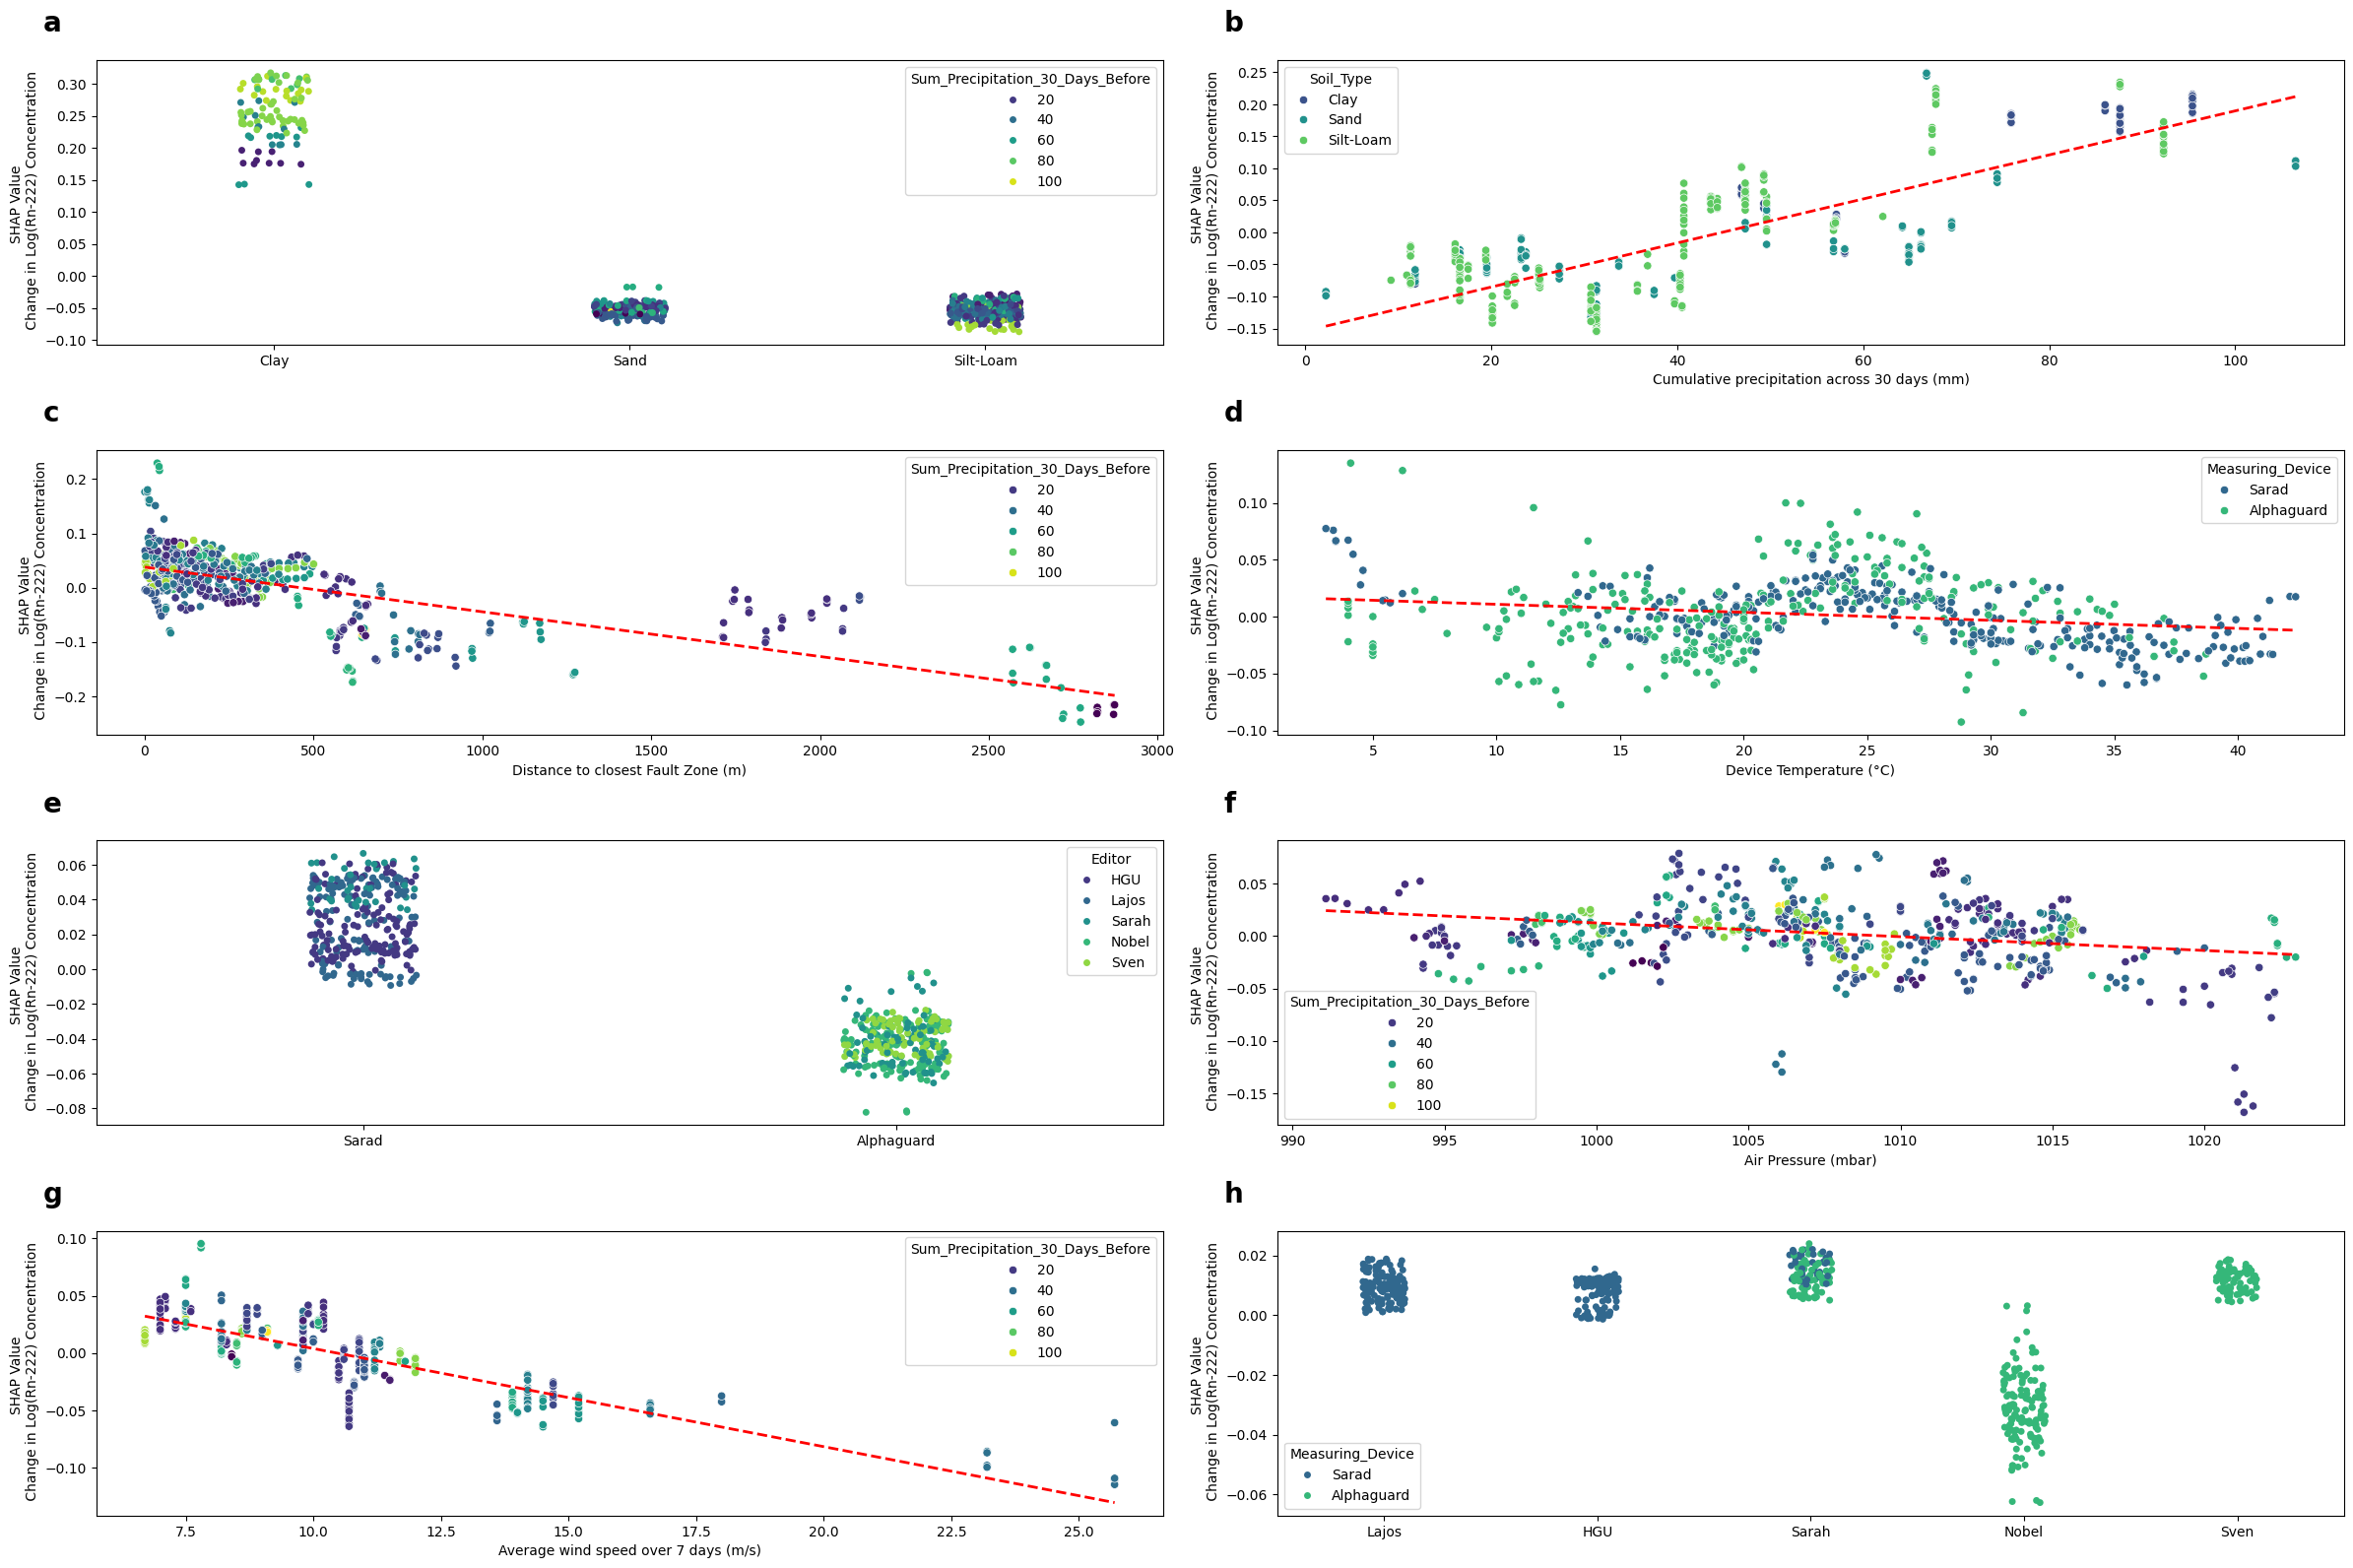

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(4, 2, figsize=(24, 16))

# Define labels for subplots
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# Soil_Type
sns.stripplot(x='Soil_Type', y='Soil_Type_Clay', data=shap_values_df, hue=data['Sum_Precipitation_30_Days_Before'], palette='viridis', ax=axs[0, 0])
axs[0, 0].set_xlabel('')
axs[0, 0].text(-0.05, 1.1, subplot_labels[0], transform=axs[0, 0].transAxes, size=20, weight='bold')
axs[0, 0].set_xticklabels(['Clay', 'Sand', 'Silt-Loam'])

# Sum_Precipitation_30_Days_Before
sns.scatterplot(x=X_preprocessed['Sum_Precipitation_30_Days_Before'], y=shap_values_df['Sum_Precipitation_30_Days_Before'], hue=data['Soil_Type'], palette='viridis', ax=axs[0, 1])
x_vals = np.array(X_preprocessed['Sum_Precipitation_30_Days_Before'])
y_vals = np.array(shap_values_df['Sum_Precipitation_30_Days_Before'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[0, 1].plot(xp, p(xp), "r--", linewidth=2)
axs[0, 1].text(-0.05, 1.1, subplot_labels[1], transform=axs[0, 1].transAxes, size=20, weight='bold')
axs[0, 1].set_xlabel('Cumulative precipitation across 30 days (mm)')

# Distance2Closest_Fault
sns.scatterplot(x=X_preprocessed['Distance2Closest_Fault'], y=shap_values_df['Distance2Closest_Fault'], hue=data['Sum_Precipitation_30_Days_Before'], palette='viridis', ax=axs[1, 0])
x_vals = np.array(X_preprocessed['Distance2Closest_Fault'])
y_vals = np.array(shap_values_df['Distance2Closest_Fault'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[1, 0].plot(xp, p(xp), "r--", linewidth=2)
axs[1, 0].text(-0.05, 1.1, subplot_labels[2], transform=axs[1, 0].transAxes, size=20, weight='bold')
axs[1, 0].set_xlabel('Distance to closest Fault Zone (m)')

# Device_Temperature
sns.scatterplot(x=X_preprocessed['Device_Temperature'], y=shap_values_df['Device_Temperature'], hue=data['Measuring_Device'], palette='viridis', ax=axs[1, 1])
x_vals = np.array(X_preprocessed['Device_Temperature'])
y_vals = np.array(shap_values_df['Device_Temperature'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[1, 1].plot(xp, p(xp), "r--", linewidth=2)
axs[1, 1].text(-0.05, 1.1, subplot_labels[3], transform=axs[1, 1].transAxes, size=20, weight='bold')
axs[1, 1].set_xlabel('Device Temperature (°C)')

# Measuring_Device
sns.stripplot(x='Measuring_Device', y='Measuring_Device_Alphaguard', data=shap_values_df, hue=data['Editor'], palette='viridis', ax=axs[2, 0])
axs[2, 0].set_xlabel('')
axs[2, 0].text(-0.05, 1.1, subplot_labels[4], transform=axs[2, 0].transAxes, size=20, weight='bold')
axs[2, 0].set_xticklabels(['Sarad', 'Alphaguard'])

# Air_Pressure
sns.scatterplot(x=X_preprocessed['Air_Pressure'], y=shap_values_df['Air_Pressure'], hue=data['Sum_Precipitation_30_Days_Before'], palette='viridis', ax=axs[2, 1])
x_vals = np.array(X_preprocessed['Air_Pressure'])
y_vals = np.array(shap_values_df['Air_Pressure'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[2, 1].plot(xp, p(xp), "r--", linewidth=2)
axs[2, 1].text(-0.05, 1.1, subplot_labels[5], transform=axs[2, 1].transAxes, size=20, weight='bold')
axs[2, 1].set_xlabel('Air Pressure (mbar)')

# Average_Wind_Speed_7_Days_Before
sns.scatterplot(x=X_preprocessed['Average_Wind_Speed_7_Days_Before'], y=shap_values_df['Average_Wind_Speed_7_Days_Before'], hue=data['Sum_Precipitation_30_Days_Before'], palette='viridis', ax=axs[3, 0])
x_vals = np.array(X_preprocessed['Average_Wind_Speed_7_Days_Before'])
y_vals = np.array(shap_values_df['Average_Wind_Speed_7_Days_Before'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[3, 0].plot(xp, p(xp), "r--", linewidth=2)
axs[3, 0].text(-0.05, 1.1, subplot_labels[6], transform=axs[3, 0].transAxes, size=20, weight='bold')
axs[3, 0].set_xlabel('Average wind speed over 7 days (m/s)')

# Editor
sns.stripplot(x='Editor', y='Editor_Nobel', data=shap_values_df, hue=data['Measuring_Device'], palette='viridis', ax=axs[3, 1])
axs[3, 1].set_xlabel('')
axs[3, 1].text(-0.05, 1.1, subplot_labels[7], transform=axs[3, 1].transAxes, size=20, weight='bold')
axs[3, 1].set_xticklabels(['Lajos', 'HGU', 'Sarah', 'Nobel', 'Sven'])

# Update some labels
for ax in axs.flat:
    ax.set_ylabel('SHAP Value \n Change in Log(Rn-222) Concentration')

plt.tight_layout()
plt.show()


### Final SHAP Value Visualizations

This cell generates the comprehensive set of SHAP value plots with enhanced aesthetics to facilitate a clearer and more insightful interpretation of the model's feature impacts. Key enhancements include:

- **Customized Color Palettes**: Distinct color schemes for different categories to improve visual differentiation.
- **Larger and Clearer Labels**: Enhanced font sizes for titles, axis labels, and legends to ensure readability.
- **Refined Legends**: Updated legends with meaningful labels and organized layouts for better clarity.
- **Consistent Layouts**: Uniform subplot arrangements and sizing for a cohesive presentation.
- **Trend Lines**: Added regression lines to highlight trends within the scatter plots.

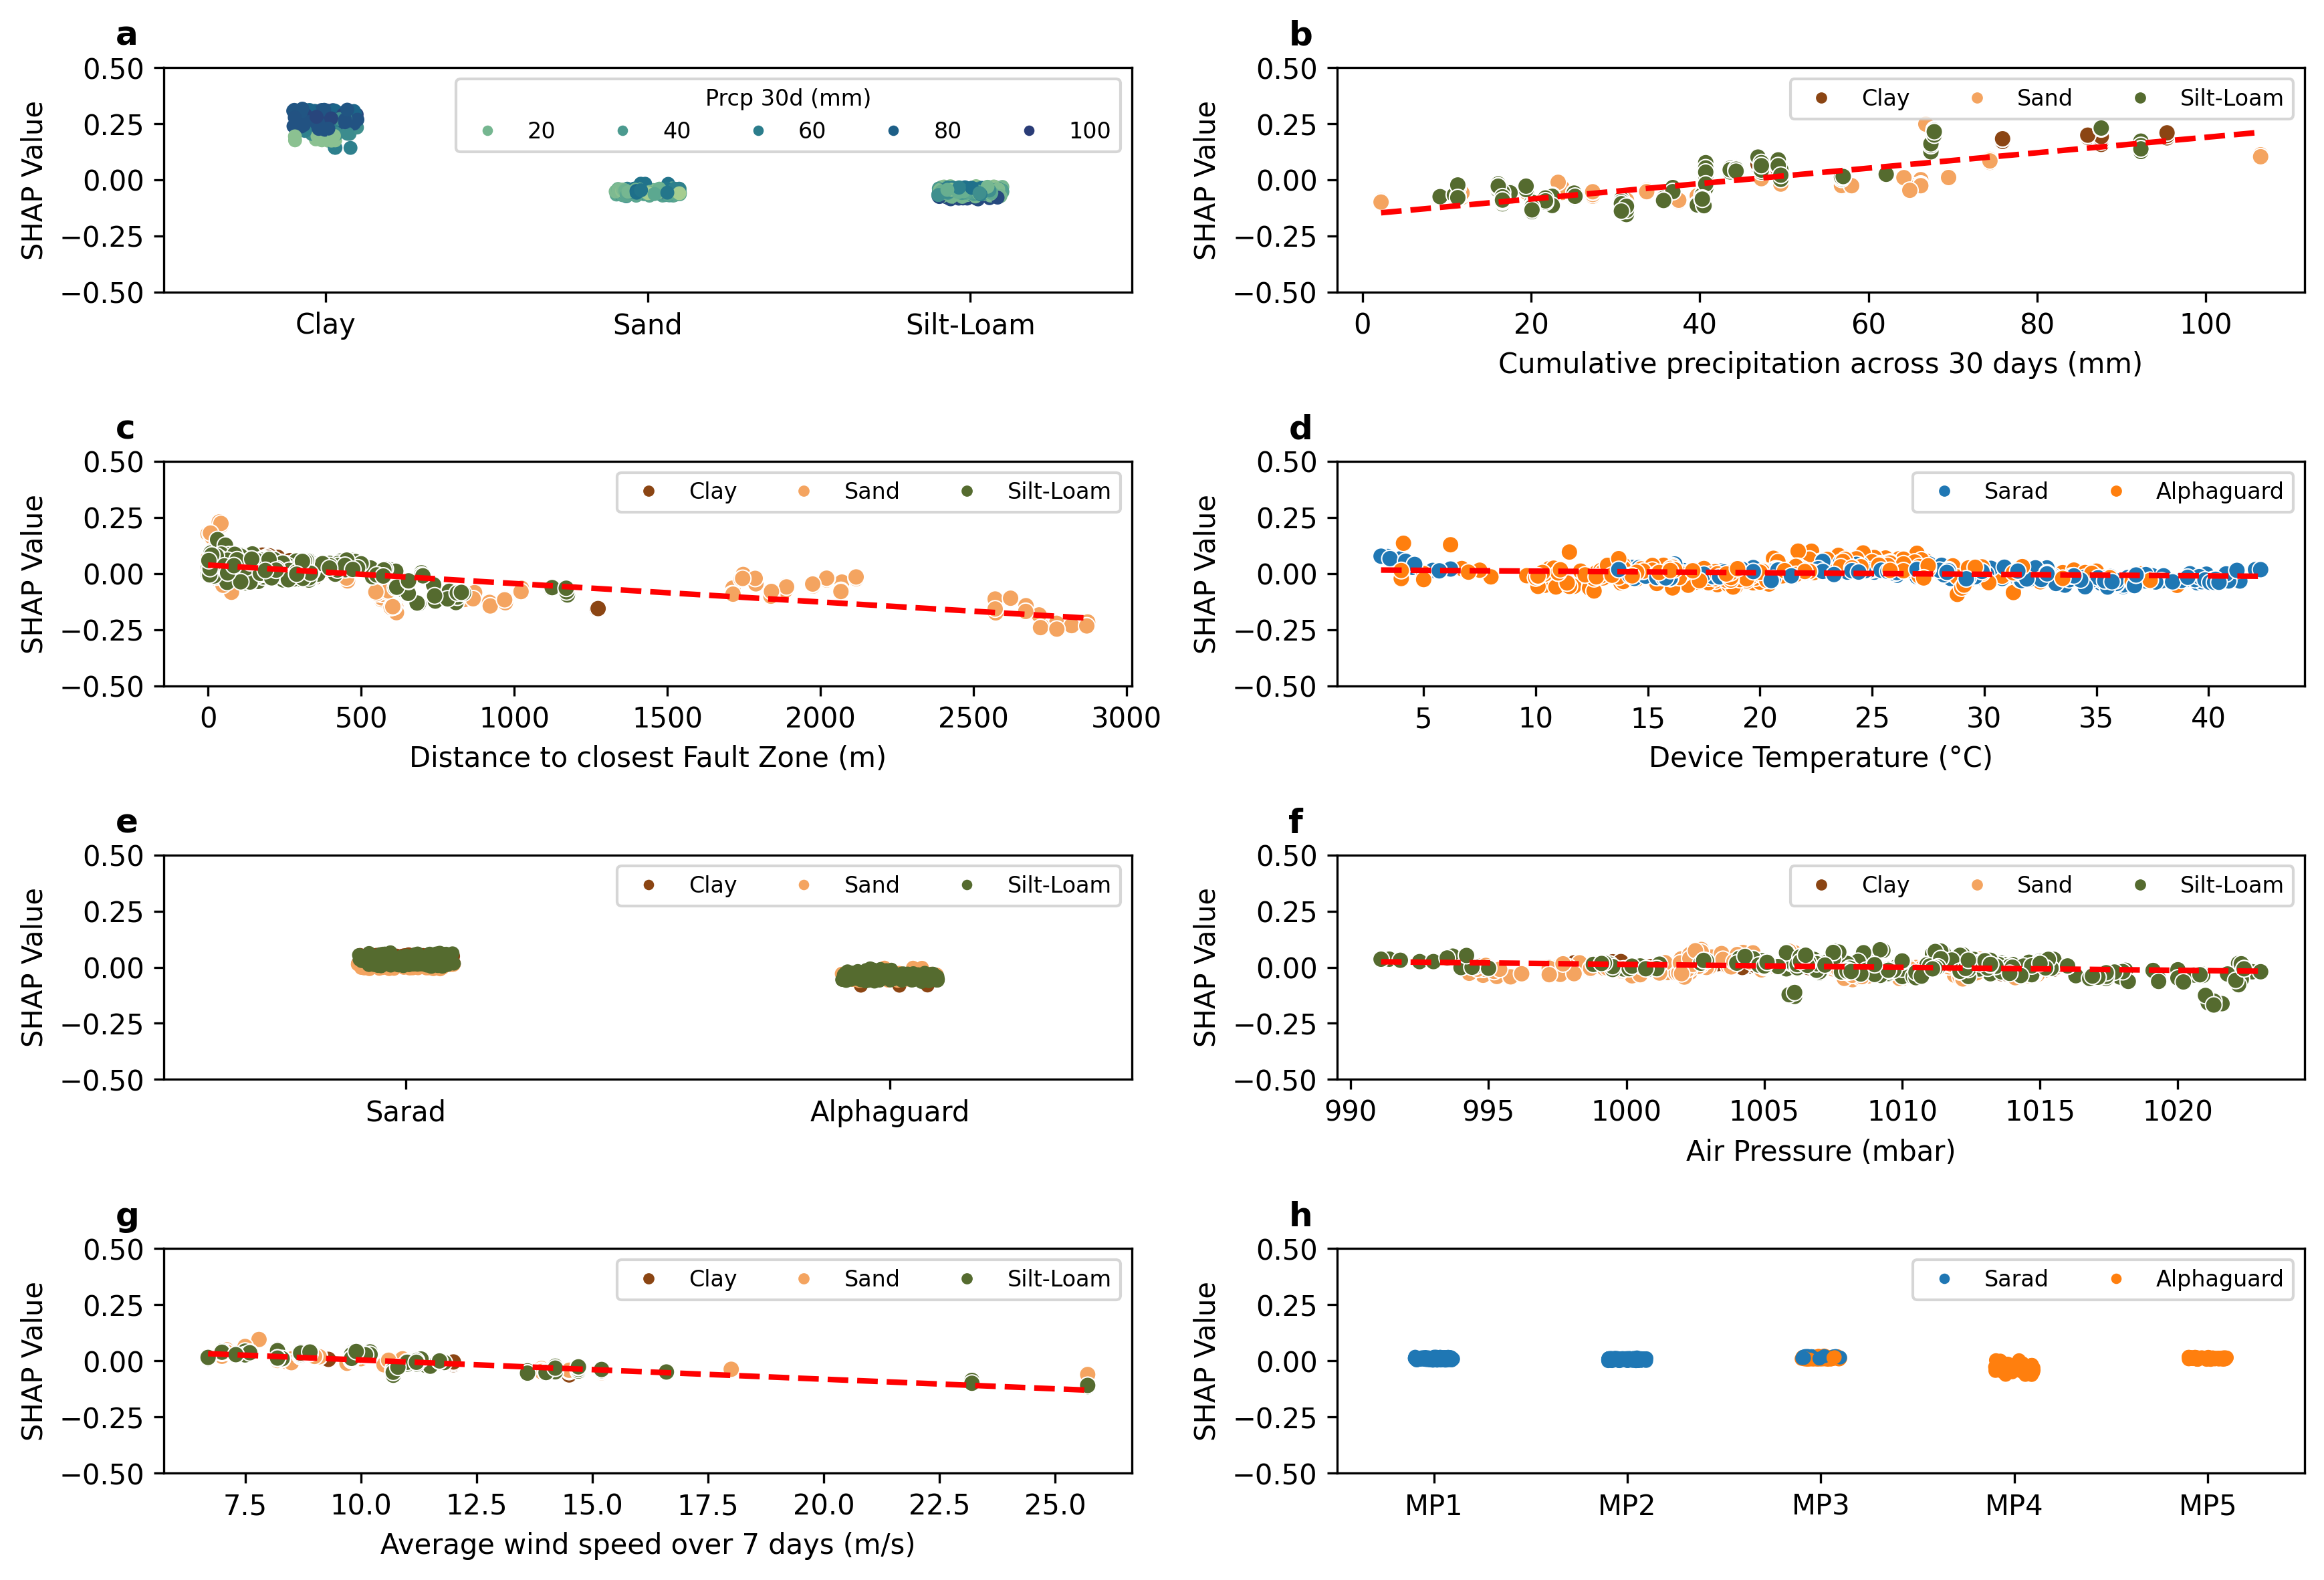

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mapping for the Editor names to MP1 to MP5
editor_mapping = {
    'Lajos': 'MP1',
    'HGU': 'MP2',
    'Sarah': 'MP3',
    'Nobel': 'MP4',
    'Sven': 'MP5'
}

# Update the data for 'Editor' with the new mapping
data['Editor'] = data['Editor'].map(editor_mapping)


soilpalette = {'Clay': '#8B4513', 'Sand': '#F4A460', 'Silt-Loam': '#556B2F'}
soilpalette2 = {'Soil_Type_Clay': '#8B4513', 'Soil_Type_Sand': '#F4A460', 'Soil_Type_Silt-Loam': '#556B2F'}

fig, axs = plt.subplots(4, 2, figsize=(11.69, 8), dpi=300)

# Define labels for subplots
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# Soil_Type
sns.stripplot(x='Soil_Type', y='Soil_Type_Clay', data=shap_values_df, hue=data['Sum_Precipitation_30_Days_Before'], palette='crest', ax=axs[0, 0])
axs[0, 0].set_xlabel('')
axs[0, 0].text(-0.05, 1.1, subplot_labels[0], transform=axs[0, 0].transAxes, size=12, weight='bold')
axs[0, 0].set_xticks(range(3))
axs[0, 0].set_xticklabels(['Clay', 'Sand', 'Silt-Loam'])
axs[0, 0].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[0, 0].get_legend_handles_labels()
# Define new labels
new_labels = ['20', '40', '60', '80', '100']
# Create a new legend with the updated labels
axs[0, 0].legend(handles, new_labels, title='Prcp 30d (mm)' , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=5)
axs[0, 0].set_ylim(-0.5 , 0.5)

# Sum_Precipitation_30_Days_Before
sns.scatterplot(x=X_preprocessed['Sum_Precipitation_30_Days_Before'], y=shap_values_df['Sum_Precipitation_30_Days_Before'], hue=data['Soil_Type'], palette=soilpalette, ax=axs[0, 1])
x_vals = np.array(X_preprocessed['Sum_Precipitation_30_Days_Before'])
y_vals = np.array(shap_values_df['Sum_Precipitation_30_Days_Before'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[0, 1].plot(xp, p(xp), "r--", linewidth=2)
axs[0, 1].text(-0.05, 1.1, subplot_labels[1], transform=axs[0, 1].transAxes, size=12, weight='bold')
axs[0, 1].set_xlabel('Cumulative precipitation across 30 days (mm)')
axs[0, 1].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[0, 1].get_legend_handles_labels()
# Define new labels
new_labels = ['Clay', 'Sand', 'Silt-Loam']
# Create a new legend with the updated labels
axs[0, 1].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[0, 1].set_ylim(-0.5 , 0.5)

# Distance2Closest_Fault
#sns.scatterplot(x=X_preprocessed['Distance2Closest_Fault'], y=shap_values_df['Distance2Closest_Fault'], hue=data['Sum_Precipitation_30_Days_Before'], palette='viridis', ax=axs[1, 0])
sns.scatterplot(x=X_preprocessed['Distance2Closest_Fault'], y=shap_values_df['Distance2Closest_Fault'], hue=data['Soil_Type'], palette=soilpalette, ax=axs[1, 0])
x_vals = np.array(X_preprocessed['Distance2Closest_Fault'])
y_vals = np.array(shap_values_df['Distance2Closest_Fault'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[1, 0].plot(xp, p(xp), "r--", linewidth=2)
axs[1, 0].text(-0.05, 1.1, subplot_labels[2], transform=axs[1, 0].transAxes, size=12, weight='bold')
axs[1, 0].set_xlabel('Distance to closest Fault Zone (m)')
axs[1, 0].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[1, 0].get_legend_handles_labels()
# Define new labels
new_labels = ['Clay', 'Sand', 'Silt-Loam']
# Create a new legend with the updated labels
axs[1, 0].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[1, 0].set_ylim(-0.5 , 0.5)

# Device_Temperature
sns.scatterplot(x=X_preprocessed['Device_Temperature'], y=shap_values_df['Device_Temperature'], hue=data['Measuring_Device'], palette='tab10', ax=axs[1, 1])
x_vals = np.array(X_preprocessed['Device_Temperature'])
y_vals = np.array(shap_values_df['Device_Temperature'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[1, 1].plot(xp, p(xp), "r--", linewidth=2)
axs[1, 1].text(-0.05, 1.1, subplot_labels[3], transform=axs[1, 1].transAxes, size=12, weight='bold')
axs[1, 1].set_xlabel('Device Temperature (°C)')
axs[1, 1].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[1, 1].get_legend_handles_labels()
# Define new labels
new_labels = ['Sarad', 'Alphaguard']
# Create a new legend with the updated labels
axs[1, 1].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[1, 1].set_ylim(-0.5 , 0.5)

# Measuring_Device
sns.stripplot(x='Measuring_Device', y='Measuring_Device_Alphaguard', data=shap_values_df, hue='Soil_Type', palette=soilpalette2, ax=axs[2, 0])
axs[2, 0].set_xlabel('')
axs[2, 0].text(-0.05, 1.1, subplot_labels[4], transform=axs[2, 0].transAxes, size=12, weight='bold')
axs[2, 0].set_xticks(range(2))
axs[2, 0].set_xticklabels(['Sarad', 'Alphaguard'])
# Capture existing legend handles and labels
handles, labels = axs[2, 0].get_legend_handles_labels()
# Define new labels
new_labels = ['Clay', 'Sand', 'Silt-Loam']
# Create a new legend with the updated labels
axs[2, 0].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[2, 0].set_ylim(-0.5 , 0.5)

# Air_Pressure
sns.scatterplot(x=X_preprocessed['Air_Pressure'], y=shap_values_df['Air_Pressure'], hue=data['Soil_Type'], palette=soilpalette, ax=axs[2, 1])
x_vals = np.array(X_preprocessed['Air_Pressure'])
y_vals = np.array(shap_values_df['Air_Pressure'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[2, 1].plot(xp, p(xp), "r--", linewidth=2)
axs[2, 1].text(-0.05, 1.1, subplot_labels[5], transform=axs[2, 1].transAxes, size=12, weight='bold')
axs[2, 1].set_xlabel('Air Pressure (mbar)')
axs[2, 1].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[2, 1].get_legend_handles_labels()
# Define new labels
new_labels = ['Clay', 'Sand', 'Silt-Loam']
# Create a new legend with the updated labels
axs[2, 1].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[2, 1].set_ylim(-0.5 , 0.5)

# Average_Wind_Speed_7_Days_Before
sns.scatterplot(x=X_preprocessed['Average_Wind_Speed_7_Days_Before'], y=shap_values_df['Average_Wind_Speed_7_Days_Before'], hue=data['Soil_Type'], palette=soilpalette, ax=axs[3, 0])
x_vals = np.array(X_preprocessed['Average_Wind_Speed_7_Days_Before'])
y_vals = np.array(shap_values_df['Average_Wind_Speed_7_Days_Before'])
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
xp = np.linspace(x_vals.min(), x_vals.max(), 100)
axs[3, 0].plot(xp, p(xp), "r--", linewidth=2)
axs[3, 0].text(-0.05, 1.1, subplot_labels[6], transform=axs[3, 0].transAxes, size=12, weight='bold')
axs[3, 0].set_xlabel('Average wind speed over 7 days (m/s)')
axs[3, 0].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[3, 0].get_legend_handles_labels()
# Define new labels
new_labels = ['Clay', 'Sand', 'Silt-Loam']
# Create a new legend with the updated labels
axs[3, 0].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[3, 0].set_ylim(-0.5 , 0.5)


# Editor
sns.stripplot(x='Editor', y='Editor_Nobel', data=shap_values_df, hue=data['Measuring_Device'], palette='tab10', ax=axs[3, 1])
axs[3, 1].set_xlabel('')
axs[3, 1].text(-0.05, 1.1, subplot_labels[7], transform=axs[3, 1].transAxes, size=12, weight='bold')
axs[3, 1].set_xticks(range(5))
axs[3, 1].set_xticklabels(['MP1', 'MP2', 'MP3', 'MP4', 'MP5'])
axs[3, 1].set_ylim(-0.5 , 0.5)
# Capture existing legend handles and labels
handles, labels = axs[3, 1].get_legend_handles_labels()
# Define new labels
new_labels = ['Sarad', 'Alphaguard']
# Create a new legend with the updated labels
axs[3, 1].legend(handles, new_labels, title=None , fontsize=8, markerscale=0.75, title_fontsize=8, ncols=3)
axs[3, 1].set_ylim(-0.5 , 0.5)


# Update some labels
for ax in axs.flat:
    ax.set_ylabel('SHAP Value')

plt.tight_layout()
plt.show()
